In [1]:
import argparse
import torch
from coati.models.io.coati import load_e3gnn_smiles_clip_e2e
from coati.models.regression.basic_due import basic_due
from coati.utils.chem import read_sdf, write_sdf, rm_radical, sa, qed, logp
from rdkit import Chem
import random
from coati.generative.molopt import gradient_opt
from coati.generative.coati_purifications import embed_smiles
from functools import partial
from torch.nn.functional import sigmoid
import torch.nn.functional as F
import numpy as np
from coati.generative.coati_purifications import force_decode_valid_batch, embed_smiles, force_decode_valid
arg_parser = argparse.ArgumentParser(description='molecular optimization on the chemical space')
arg_parser.add_argument('--device', choices=['cuda:0', 'cpu'], \
    default='cuda:0',help='Device')
arg_parser.add_argument('--seed', type=int, default=2024) 
arg_parser.add_argument('--ecloudgen_ckpt', type=str, default = 'model_ckpts/ecloud_augmented_37.pkl')
arg_parser.add_argument('--noise', type=float, default=0.3)
args = arg_parser.parse_args([])


In [2]:
# model loading
DEVICE = torch.device(args.device)
DEVICE = 'cpu'
encoder, tokenizer = load_e3gnn_smiles_clip_e2e(
    freeze=True,
    device=DEVICE,
    # model parameters to load.
    doc_url=args.ecloudgen_ckpt,
)

Loading model from model_ckpts/ecloud_augmented_37.pkl
Loading tokenizer mar from model_ckpts/ecloud_augmented_37.pkl
number of parameters: 12.64M
number of parameters Total: 2.44M xformer: 19.60M Total: 22.04M 
Freezing encoder
44882816 params frozen!


In [3]:
class PSO_format_model():
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def seq_to_emb(self, smiles):
        if isinstance(smiles, str):
            smi_emb = embed_smiles(smiles, self.model, self.tokenizer).to(DEVICE).cpu().numpy()
            return smi_emb
        else:
            emb_list = []
            for smi in smiles:
                smi_emb = embed_smiles(smi, self.model, self.tokenizer).to(DEVICE).cpu().numpy()
                emb_list.append(smi_emb)
                # torch.stack(emb_list).reshape(-1, 256)
            return np.stack(emb_list).reshape(-1, 256)

    
    def emb_to_seq(self, embs):
        ## if isinstance(embs, torch.Tensor):
        
        seq_list = []
        for emb in embs:
            emb = torch.tensor(emb).to(self.device)
            seq = force_decode_valid_batch(emb, self.model, self.tokenizer)
            seq_list.append(seq)
        return seq_list

In [4]:
ecloud_latent = PSO_format_model(encoder, tokenizer, DEVICE)
init_smiles = "c1ccccc1"
init_emb = ecloud_latent.seq_to_emb([init_smiles, init_smiles])

In [5]:
from coati.optimize.optimizer import BasePSOptimizer
from coati.optimize.scoring import ScoringFunction
from coati.optimize.mol_functions import qed_score

/home/haotian/Molecule_Generation/MG/backupECloud/EcloudGen-COATI/coati/optimize/mol_functions.py:212: UserWarning: failed to load reward_penalized_log_p score. Consider installing package networkx
  warnings.warn("failed to load reward_penalized_log_p score. Consider installing package networkx")


In [6]:
scoring_functions = [ScoringFunction(func=qed_score, name="qed", is_mol_func=True)] 
init_smiles = "c1ccccc1"
pso_opt = BasePSOptimizer.from_query(
    init_smiles=init_smiles,
    num_part=200,
    num_swarms=1,
    inference_model=ecloud_latent,
    scoring_functions=scoring_functions)

In [7]:
pso_opt.run(20)

[0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837
 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837
 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837
 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837
 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837
 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837
 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837
 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837
 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837
 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837
 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837
 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837
 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837
 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837
 0.44262837 0.44262837 0.44262837 0.44262837 0.44262837 0.4426

/home/haotian/Molecule_Generation/MG/backupECloud/EcloudGen-COATI/coati/optimize/optimizer.py:96: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.best_solutions = pd.concat([self.best_solutions, new_df], ignore_index=True)


In [19]:
init_emb[0].shape

torch.Size([256])

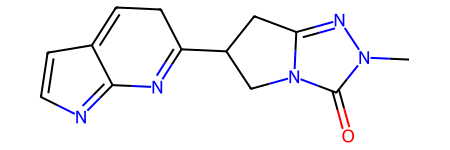

In [40]:
Chem.MolFromSmiles(init_smi)

In [37]:
force_decode_valid_batch(init_emb_vec, encoder, tokenizer)

'C'

In [38]:
force_decode_valid(init_emb_vec, encoder, tokenizer)

'C'

In [29]:
smiles = force_decode_valid_batch(init_emb, encoder, tokenizer)

In [12]:

smiles = force_decode_valid_batch(init_emb, encoder, tokenizer)

class PSO_format_model():
    def __init__(self, model, tokenizer, device):
        self.model = model
        self.tokenizer = tokenizer
        self.device = device

    def seq_to_emb(self, smiles):
        if isinstance(smiles, str):
            smiles = [smiles]
        emb_list = []
        for smi in smiles:
            with torch.no_grad():
                smi_emb = embed_smiles(smi, self.model, self.tokenizer).to(DEVICE)
                emb_list.append(smi_emb)
        return torch.stack(emb_list).reshape(-1, 256)
    
    def emb_to_seq(self, emb):
        if isinstance(emb, torch.Tensor):
            emb = emb.unsqueeze(0)
        with torch.no_grad():
            return force_decode_valid_batch(emb, self.model, self.tokenizer)

In [ ]:
emb

In [5]:
from coati.utils.chem import read_pkl

traj_three = read_pkl('./results/conditions_tmp/4bel_bump_dockingqedsa.pkl')[1:]
qed_traj = read_pkl('./results/conditions_tmp/4bel_bump_qed.pkl')[1:]
sa_traj = read_pkl('./results/conditions_tmp/4bel_bump_sa.pkl')[1:]
docking_traj = read_pkl('./results/conditions_tmp/4bel_bump_docking.pkl')[1:]

qeds = [item['qed'] for item in qed_traj]
sas = [item['sa'] for item in sa_traj]
dockings = [item['docking'] for item in docking_traj]


three_qeds = [item['qed'] for item in traj_three]
three_sas = [item['sa'] for item in traj_three]
three_dockings = [item['docking'] for item in traj_three]


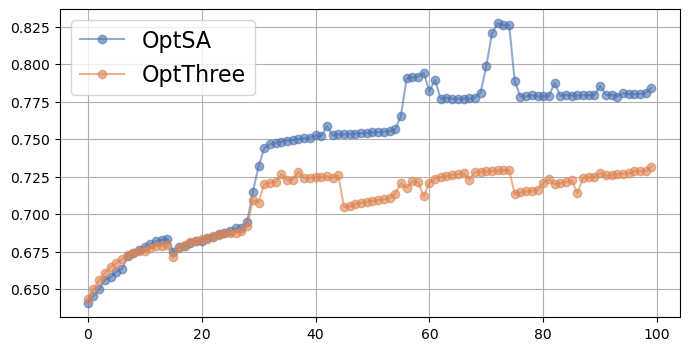

In [129]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

data1 = sas
data2 = three_sas
# 创建一个索引列表，用于x轴的值
x = list(range(len(data1)))
# x = list(range(0, len(data1)*5, 5))
# 使用Seaborn的颜色
colors = sns.color_palette("deep")  # 获取Seaborn的默认深色调色板

# 使用matplotlib绘图
fig, ax = plt.subplots(figsize=(8, 4))

# 使用第一个Seaborn颜色来绘制线条
ax.plot(x, data1, marker='o', linestyle='-', color=colors[0], alpha=0.6, label='OptSA')
ax.plot(x, data2, marker='o', linestyle='-', color=colors[1], alpha=0.6, label='OptThree')
ax.legend(fontsize=16)
# 设置x轴和y轴的刻度间隔
# x_major_locator = MultipleLocator(2)  # x轴每隔2个单位显示一个主刻度标记
# y_major_locator = MultipleLocator(0.05)  # y轴每隔0.1显示一个主刻度标记

# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

ax.grid(True)  # 显示网格

plt.show()

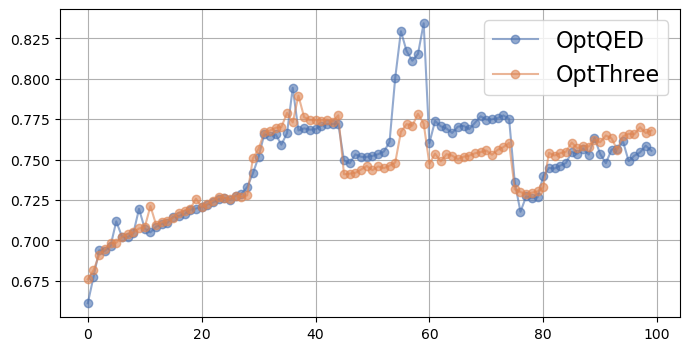

In [135]:
# Sample data, replace 'sas' and 'three_sas' with your actual data arrays
data1 = qeds
data2 = three_qeds
# Creating an index list for the x-axis values
x = list(range(len(data1)))

# Using Seaborn's color palette
colors = sns.color_palette("deep")  # Accessing Seaborn's default deep color palette

# Creating a plot
fig, ax = plt.subplots(figsize=(8, 4))

# Plotting the data using the first two colors from the Seaborn palette
ax.plot(x, data1, marker='o', linestyle='-', color=colors[0], alpha=0.6, label='OptQED')
ax.plot(x, data2, marker='o', linestyle='-', color=colors[1], alpha=0.6, label='OptThree')
ax.legend(fontsize=16)

# Optionally set the locator for major ticks
# ax.xaxis.set_major_locator(MultipleLocator(2))  # Major ticks interval on x-axis
# ax.yaxis.set_major_locator(MultipleLocator(0.05))  # Major ticks interval on y-axis

ax.grid(True)  # Enabling grid

# Display the plot
plt.show()

# Saving the figure in high resolution
fig.savefig("OptQED.png", dpi=300)  # Save as PNG with 300 DPI

In [6]:
from PIL import Image
import io
def save_img(ipy_Image, out_file):
    img_byte_arr = io.BytesIO(ipy_Image.data)
    img_pil = Image.open(img_byte_arr)
    img_pil.save(out_file)
    print('saved at {}'.format(out_file))

In [ ]:
from rdkit.Chem import Draw
import os
import os.path as osp

idx = 30
save_base = './results/conditions_tmp/docking'
os.makedirs(save_base, exist_ok=True)
for idx in range(100):
    mol = [Chem.MolFromSmiles(qed_traj[idx]['smiles'])]
    QED = qed_traj[idx]['qed']
    SA = sa_traj[idx]['sa']
    Docking = docking_traj[idx]['docking']

    legend_qed = f'S: {idx} QED: {QED:.2f}'
    legend_sa = f'S: {idx} SA: {SA:.2f}'
    legend_docking = f'S: {idx} Docking: {Docking:.2f}'

    img = Draw.MolsToGridImage(mol, molsPerRow=1, subImgSize=(200, 200), legends=[legend_qed])
    img

    save_img(img, osp.join(save_base, f'qed_{idx}.png'))

In [ ]:
from rdkit.Chem import Draw

save_base = './results/conditions_tmp/three'
os.makedirs(save_base, exist_ok=True)
for idx in range(100):
    mol = [Chem.MolFromSmiles(traj_three[idx]['smiles'])]
    QED = traj_three[idx]['qed']
    SA = traj_three[idx]['sa']
    Docking = traj_three[idx]['docking']
    legend = f'T: {idx} QED: {QED:.2f}, SA: {SA:.2f}, Docking: {Docking:.2f}'
    legend_qed = f'T: {idx} QED: {QED:.2f}'
    legend_sa = f'T: {idx} SA: {SA:.2f}'
    legend_docking = f'T: {idx} Docking: {Docking:.2f}'

    img = Draw.MolsToGridImage(mol, molsPerRow=1, subImgSize=(200, 200), legends=[legend])
    img

    save_img(img, osp.join(save_base, f'three_{idx}.png'))

In [ ]:
init_smi = init_smiles[0]

In [ ]:
init_mol = [Chem.MolFromSmiles(init_smi)]
init_qed = get_qed(init_emb_vec).detach().cpu().numpy().item()
init_sa = get_sa(init_emb_vec).detach().cpu().numpy().item()
init_docking = get_docking(init_emb_vec).detach().cpu().numpy().item()
legend = f'QED: {init_qed:.2f}, SA: {init_sa:.2f}, Docking: {init_docking:.2f}'
legend_qed = f'QED: {0.66:.2f}'
legend_sa = f'SA: {0.64:.2f}'
legend_docking = f'Docking: {-7.4:.2f}'
img = Draw.MolsToGridImage(init_mol, molsPerRow=1, subImgSize=(200, 200), legends=[legend_docking])
img

C/C(=N\NC(=O)Cc1cccc2ccccc12)c1ccc2c3c(cccc13)CC2,4.0000
OC1(c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)CCCC1,7.0969
Nc1cc/c(=N/S(=O)(=O)c2cc(Cl)sc2Cl)[nH]c1,4.0000
Cc1ccc(C(=O)NC2CC2)cc1-c1ccc2c(=O)n(CC3CC3)nnc2c1,8.2218
[NH3+][C@@H]1CCCC[C@H]1NS(=O)(=O)c1cncc(Br)c1,4.0000

In [ ]:
smi_list = [
    r"C/C(=N\NC(=O)Cc1cccc2ccccc12)c1ccc2c3c(cccc13)CC2",
    r"OC1(c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)CCCC1",
    r'Nc1cc/c(=N/S(=O)(=O)c2cc(Cl)sc2Cl)[nH]c1',
    r'Cc1ccc(C(=O)NC2CC2)cc1-c1ccc2c(=O)n(CC3CC3)nnc2c1',
    r'[NH3+][C@@H]1CCCC[C@H]1NS(=O)(=O)c1cncc(Br)c1'
]

subset = []
for smi in smi_list:
    init_smi = Chem.MolToSmiles(Chem.MolFromSmiles(f'{smi}'))
    init_emb_vec = embed_smiles(init_smi, encoder, tokenizer).to(DEVICE)
    logp = get_logp(init_emb_vec)
    pic50 = get_pic50(init_emb_vec)
    hist = {"smiles": init_smi, "embed_smiles": init_emb_vec.cpu().numpy()[0], "pic50":pic50.detach().cpu().numpy()[0], "logp":logp.detach().cpu().numpy()[0]}
    subset.append(hist)

In [ ]:
def write_pkl(subset, path):
    import pickle
    with open(path, 'wb') as f:
        pickle.dump(subset, f)

In [ ]:
write_pkl(subset, './results/conditions_tmp/mk14_init.pkl')

In [ ]:

smi_list = [
    r"C/C(=N\NC(=O)Cc1cccc2ccccc12)c1ccc2c3c(cccc13)CC2",
    r"OC1(c2nc(-c3ccc(F)cc3)c(-c3ccncc3)[nH]2)CCCC1",
    r'Nc1cc/c(=N/S(=O)(=O)c2cc(Cl)sc2Cl)[nH]c1',
    r'Cc1ccc(C(=O)NC2CC2)cc1-c1ccc2c(=O)n(CC3CC3)nnc2c1',
    r'[NH3+][C@@H]1CCCC[C@H]1NS(=O)(=O)c1cncc(Br)c1'
]
for i, smi in enumerate(smi_list):
    objective_fcn = lambda v: - get_pic50(v)
    init_smi = Chem.MolToSmiles(Chem.MolFromSmiles(f'{smi}'))

    init_emb_vec = embed_smiles(init_smi, encoder, tokenizer).to(DEVICE)
    traj = gradient_opt(
        init_emb_vec = init_emb_vec,
        objective_fcn = objective_fcn_dict[task],  # the constraints below will be added to this.
        encoder = encoder,
        tokenizer = tokenizer,
        add_bump=True,
        constraint_functions={
            "logp_p": get_logp_penalty,
        },  # enforced to == 0 by lagrange multipliers.
        log_functions={
            "logp": get_logp,
            # "qed": get_qed,
            # "sa": get_sa,
            "pic50": get_pic50,
            # "docking": get_docking,
        },  # These log functions will get appended to the history list-dict returned.
        nsteps=4000,
        save_traj_history=f'./results/conditions_tmp/pic50_{i}.pkl',
        save_every=1,
        project_every=15,
        report=False,
    )

    smiles_list = [i['smiles'] for i in traj]
    mols_list = [Chem.MolFromSmiles(i) for i in smiles_list]
    # all_mols.extend(mols_list[-4:])

    # write_sdf(all_mols, f'./results/conditions_tmp/4bel_proj_{task}.sdf')

In [21]:
traj = read_pkl('./results/conditions_tmp/pic50_2.pkl')
logs = [item['logp'] for item in traj]
pic50s = [item['pic50'] for item in traj]
logs_reason = [i for i in logs if i < 5 and i > -2]
ratio = len(logs_reason)/len(logs)
print(ratio)

0.926018495376156


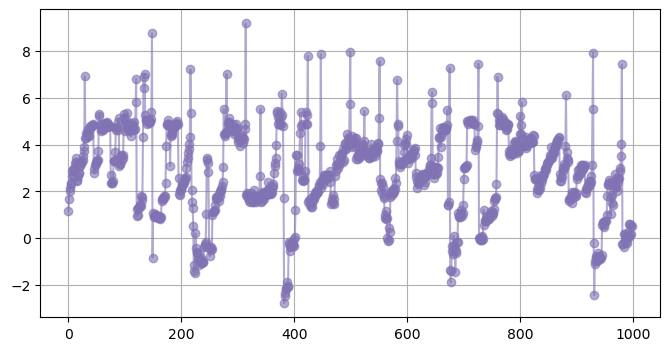

In [16]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

data = logs[1:1000]

# 创建一个索引列表，用于x轴的值
x = list(range(len(data)))

# 使用Seaborn的颜色
colors = sns.color_palette("deep")  # 获取Seaborn的默认深色调色板

# 使用matplotlib绘图
fig, ax = plt.subplots(figsize=(8, 4))

# 使用第一个Seaborn颜色来绘制线条
ax.plot(x, data, marker='o', linestyle='-', color=colors[4], alpha=0.6)

# 设置x轴和y轴的刻度间隔
# x_major_locator = MultipleLocator(2)  # x轴每隔2个单位显示一个主刻度标记
# y_major_locator = MultipleLocator(0.05)  # y轴每隔0.1显示一个主刻度标记

# ax.xaxis.set_major_locator(x_major_locator)
# ax.yaxis.set_major_locator(y_major_locator)

ax.grid(True)  # 显示网格
plt.show()

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
Draw.MolsToGridImage(mols_list, molsPerRow=4,subImgSize=(200,200))

In [ ]:
smiles_list = [i['smiles'] for i in traj]
mols_list = [Chem.MolFromSmiles(i) for i in smiles_list]
random.shuffle(mols_list)

In [ ]:
pred_qed_list = [i['qed'] for i in traj]
smiles_list = [i['smiles'] for i in traj]
mols_list = [Chem.MolFromSmiles(i) for i in smiles_list]
qed_list = [qed(i) for i in mols_list]

In [ ]:
len(pred_qed_list)

In [ ]:
qed_list

In [ ]:
init_mols[0].RemoveAllConformers()

In [ ]:
init_mols[0]

In [ ]:
mols_list[0]

In [ ]:
qed_list

In [ ]:
nsteps = 2000
meta_traj_no_binding = []